# Tutorial 3b. Multilayer Perceptrons with Auto-differentiation!
# Everything is here!! https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

- In this tutorial you will train (again) a multilayer perceptron

- But differently from what you did in `tutorial3a`, since this time, you will let the `PyTorch` library do most of the complicated work for you

- The goal of this notebook is to make you get familiar with `PyTorch` and the its main concepts, that we will use repeatedly along the course.

- We will be training a multilayer perceptron on the `CIFAR-10` dataset, a popular dataset of images that is used in Computer-Vision (CV) research

- You will need to use a lot the documentation of `PyTorch` and look at examples for this notebook.

In [49]:
import torch, torchvision
import shutil
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt 
import multiprocessing

## Load the dataset

- `PyTorch` provides popular computer vision datasets that can be easily downloaded
- The following code will download the `CIFAR-10` dataset for us  
- Since it is computationally expensive to load the entire dataset into memory, we will use `PyTorch`'s dataloaders  before feeding batches of images to the neural network

**QUESTION.** Fill in the next cell

In [71]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
testset = datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
# Based on different papers using CIFAR-10 https://www.arxiv-vanity.com/papers/1804.07612/
batch_size = 4

# Verify how many cores the computer has and assign all of them to the task
num_workers = multiprocessing.cpu_count()

# Fill in the options for both data loaders. Warning: the training dataloader should shuffle the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Visualize the Images of CIFAR-10

* Once everything is properly loaded you should be able to visualize some of the samples of the CIFAR-10

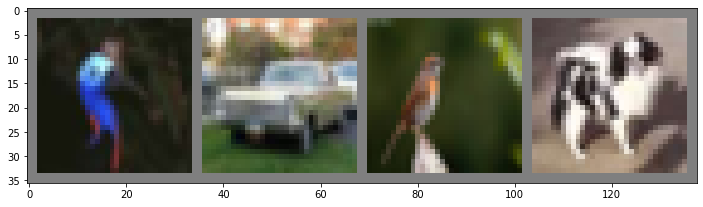

 bird   car  bird   dog


In [74]:
def show_images(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Creating a MLP model and train it

- We are now ready to define all the necessary hyperparameters that are required to construct a proper MLP
- Similarly to what we did in `tutorial03a` we need to explore the data carefully in order to know how to set the following parameters

### Hyperparameters

There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:
1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
3. The number of hidden neurons should be less than twice the size of the input layer.

There's a geometric pyramid rule that says that whre input has m nodes and output has n nodes, the hidden layer should have  sqrt(m∗n)

In [30]:
input_dim = 3*32*32
hidden_dim = 175
output_dim = 10
learning_rate = .001
num_epochs = 100

### Computation Graph

- You are free to define any kind of architecture that you think is reasonable for the problem of classifying CIFAR-10 images
- By default, you can use a multi-layer perceptron
- The constructor of the neural network will represent the different components of the computation-graph, note that it is very similar to the way we have programmed our own neural network in `tutorial03a`.
- You will also have to define the forward pass yourself.

In [133]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.input_size = input_dim
        self.hidden_size  = hidden_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        #self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        #self.fc1 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_dim)
        self.softmax = torch.nn.Softmax(dim=0)
        
    def forward(self, X):
        X = X.view(-1, 3 * 32 * 32)
        hidden = self.fc1(X)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.softmax(output)
        return output

### Create the Network

- You are now ready to create your neural network object
- You will also have to define an appropriate loss function to minimize and an optimization algorithm
- By default, you can use the cross-entropy loss and the RMS prop optimizer

In [170]:
model = Net(input_dim, hidden_dim, output_dim)

# CrossEntropyLoss() for a multi-class classification problem like ours
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### Train the Network

- Once you have your neural network you just need to train it. 
- You will have to compute the output of the forward pass, compare it to your desired output and update the parameters of the network by backpropagation. 
- Fortunately this time, this only requires less than 5 lines of code in `PyTorch`

In [147]:
def train(model, optimizer, num_epochs, start_epoch, batch_size, learning_rate, trainloader, cuda):
    iters, losses = [], []
    iters_sub, train_acc, val_acc = [], [] ,[]
    # training
    if cuda:
        print("CUDA training ACTIVE")
        model.to(device)
    n = 0 # the number of iterations
    for epoch in range(start_epoch, num_epochs):
        print("\nEpoch: ", epoch)
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            
            #CUDA training
            if cuda:
                inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('     [%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_ckp(checkpoint, False, "training_checkpoints/")
        print("Final epoch loss: {:0.3f}".format(float(loss)/batch_size))
            
    save_ckp(checkpoint, True, "training_checkpoints/")
    
    return model

def get_accuracy(model, data):
    loader = torch.utils.data.DataLoader(data, batch_size=500)
    correct, total = 0, 0
    for xs, ts in loader:
        xs = xs.view(-1, 3*32*32) # flatten the image
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(ts.view_as(pred)).sum().item()
        total += int(ts.shape[0])
    return correct / total

def save_ckp(state, final_model, checkpoint_dir):
    f_path = checkpoint_dir + 'checkpoint.pt'
    torch.save(state, f_path)
    if final_model:
        torch.save(state, "models/finalmodel.pt")

def load_ckp(checkpoint_fpath, model, optimizer):
    try:
        checkpoint = torch.load(checkpoint_fpath)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch_checkpoint = checkpoint['epoch']
    except:
        epoch_checkpoint = 0
        
    return model, optimizer, epoch_checkpoint


In [174]:
ckp_path = "training_checkpoints/checkpoint.pt"
model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer)
train(model, optimizer, num_epochs, start_epoch, batch_size, learning_rate, trainloader, False)

UnboundLocalError: local variable 'checkpoint' referenced before assignment

## CUDA training of the neural network

In [172]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.to(device)
#ckp_path = "training_checkpoints/checkpoint.pt"
#model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer)
#train(model, optimizer, num_epochs, start_epoch, batch_size, learning_rate, trainloader, True)

- Of course, repeated calls to `train` will continue training from where it were
- Training a neural network is a highly iterative process.

## Evaluate the final performance of the Network

- Once you think your network is properly trained, you will test its performance on the testing-set of the CIFAR-10 dataset
- Compute the final accuracy of your model
- You should be able to reach a 50% accuracy with a simple multi-layer perceptron

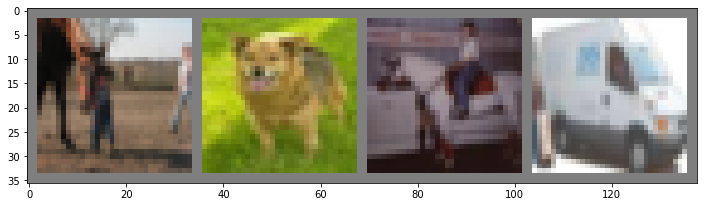

GroundTruth:  horse   dog horse truck


In [175]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
show_images(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [181]:
def test(model):
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    show_images(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
    
    model, _, _ = load_ckp(ckp_path, model, optimizer)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

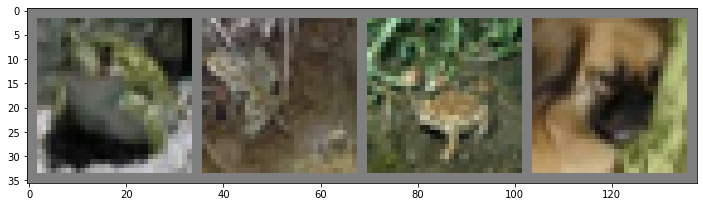

GroundTruth:   frog  frog  frog   dog
Predicted:  truck  bird  frog   dog
Accuracy of the network on the 10000 test images: 42 %
Accuracy of plane : 47 %
Accuracy of   car : 52 %
Accuracy of  bird : 30 %
Accuracy of   cat : 26 %
Accuracy of  deer : 32 %
Accuracy of   dog : 33 %
Accuracy of  frog : 49 %
Accuracy of horse : 49 %
Accuracy of  ship : 55 %
Accuracy of truck : 45 %


In [183]:
test(model)

**Final remark.** Of course, this is far from being the state-of-the-art. Indeed, convolutional neural nets are the backbones for computer vision problems (we will do it in following labs), while we only used here a feed-forward network.

## Redo it using `pytorch-lightning`

There is some boilerplates in pure `PyTorch` code. The `pytorch-lightning` library is a new library allowing to simplify a lot the use of `PyTorch` together with very nice options for faster training and development.

In [185]:
import pytorch_lightning as pl

In [211]:
class LightNet(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LightNet, self).__init__()
        self.input_size = input_dim
        self.hidden_size  = hidden_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        #self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        #self.fc1 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_dim)
        self.softmax = torch.nn.Softmax(dim=0)
        
    def forward(self, X):
        X = X.view(-1, 3 * 32 * 32)
        hidden = self.fc1(X)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.softmax(output)
        return output
    
    def training_step(self, batch, batch_idx):
    
        x, y = batch
        logits = self(x)
        floss = torch.nn.CrossEntropyLoss()
        loss = floss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        floss = torch.nn.CrossEntropyLoss()
        loss = floss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
     def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        floss = torch.nn.CrossEntropyLoss()
        loss = floss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

In [212]:
lightning_model = LightNet(input_dim, hidden_dim, output_dim)
trainer = pl.Trainer(gpus=-1)
trainer.fit(lightning_model, trainloader, trainset)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 537 K 
1 | relu    | ReLU    | 0     
2 | fc2     | Linear  | 1.8 K 
3 | softmax | Softmax | 0     
------------------------------------
539 K     Trainable params
0         Non-trainable params
539 K     Total params
2.158     Total estimated model params size (MB)


/home/jlechuga/anaconda3/envs/deep/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1